# Assignment 1: From Dirty Data to Predictive Models

Federico Giorgi (fg2617)

Titanic Survival Dataset

## Dataset Description

**Data Dictionary**

| Variable  | Definition                          | Key                                  |
|-----------|-------------------------------------|--------------------------------------|
| survival  | Survival                            | 0 = No, 1 = Yes                      |
| pclass    | Ticket class                        | 1 = 1st, 2 = 2nd, 3 = 3rd            |
| sex       | Sex                                 |                                      |
| age       | Age in years                        |                                      |
| sibsp     | # of siblings / spouses aboard      |                                      |
| parch     | # of parents / children aboard      |                                      |
| ticket    | Ticket number                       |                                      |
| fare      | Passenger fare                      |                                      |
| cabin     | Cabin number                        |                                      |
| embarked  | Port of Embarkation                 | C = Cherbourg, Q = Queenstown, S = Southampton |


**Variable Notes**
pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Basics

In [73]:
# Import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from sklearn.compose import ColumnTransformer, make_column_selector as selector

In [74]:
# Import the data
df_train0 = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

## 1 Exploratory data analysis and visualization

In [75]:
df_train0["Survived_label"] = df_train0["Survived"].map({0: "Did not survive", 1: "Survived"})
df_train0.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_label
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Did not survive
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Did not survive


### 1.1 Univariate Data Analysis

In [76]:
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFFF99", "#CC99FF"]

#### 1.1.1 Survival distribution

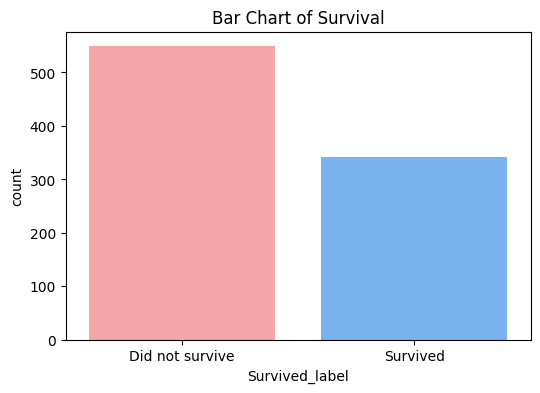

In [142]:
plt.figure(figsize=(6, 4))
sns.countplot(
    x="Survived_label",
    data=df_train0,
    palette=colors[:2],
    hue="Survived_label",
    legend=False)
plt.title("Bar Chart of Survival")
plt.show()

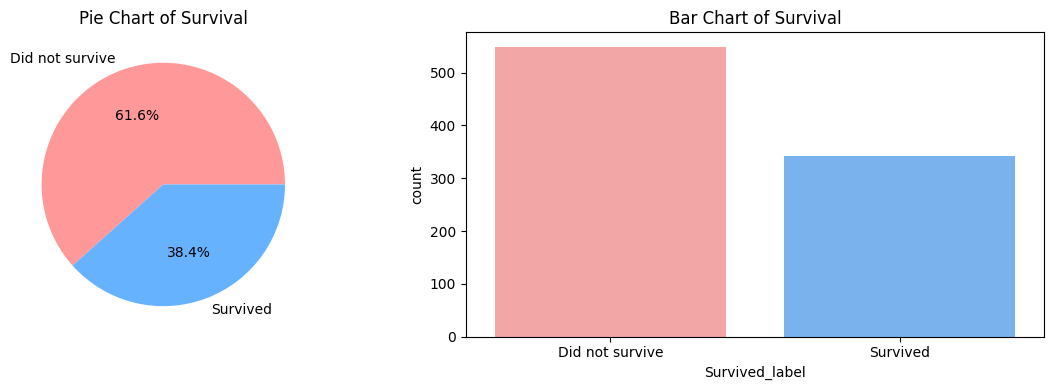

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
df_train0["Survived"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Did not survive", "Survived"],
    colors=colors[:2],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Survival")

# Bar chart
sns.countplot(
    x="Survived_label",
    data=df_train0,
    palette=colors[:2],
    ax=axes[1],
    hue="Survived_label",
    legend=False)
axes[1].set_title("Bar Chart of Survival")

plt.tight_layout()
plt.show()

The survival variable shows a clear imbalance, with about 62% of passengers not surviving and 38% surviving. This imbalance means that accuracy alone would not be a reliable performance measure, as a trivial model predicting non-survival for all cases would already achieve a high score.

#### 1.1.2 Demographic variables

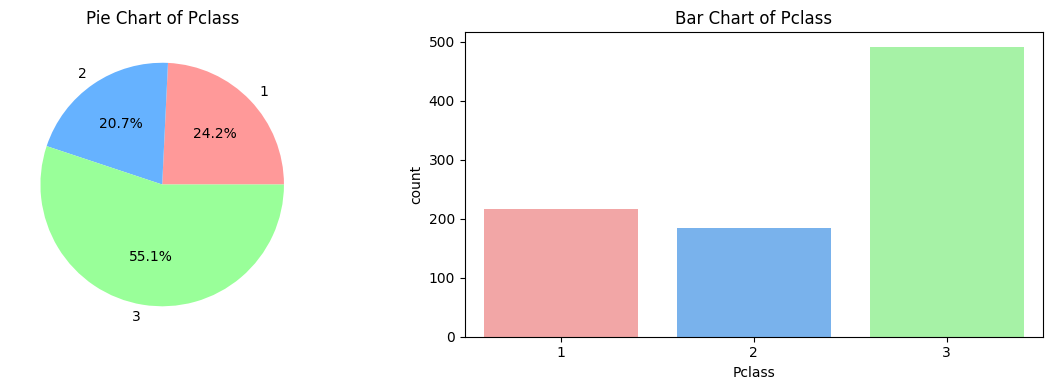

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
order = [1, 2, 3]

# Pie chart
df_train0["Pclass"].value_counts(normalize=True).reindex(order).plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=colors[:3],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Pclass")

# Bar chart
sns.countplot(
    x="Pclass",
    data=df_train0,
    order=order,
    palette=colors[:3],
    ax=axes[1],
    hue="Pclass",
    legend=False
)
axes[1].set_title("Bar Chart of Pclass")

plt.tight_layout()
plt.show()


Passenger class is unevenly distributed, with the majority of passengers in third class, fewer in first class, and the least in second class. This indicates that the dataset is skewed toward lower-class passengers, which is important for understanding how representative the sample is and sets the stage for later analysis of survival differences across classes.

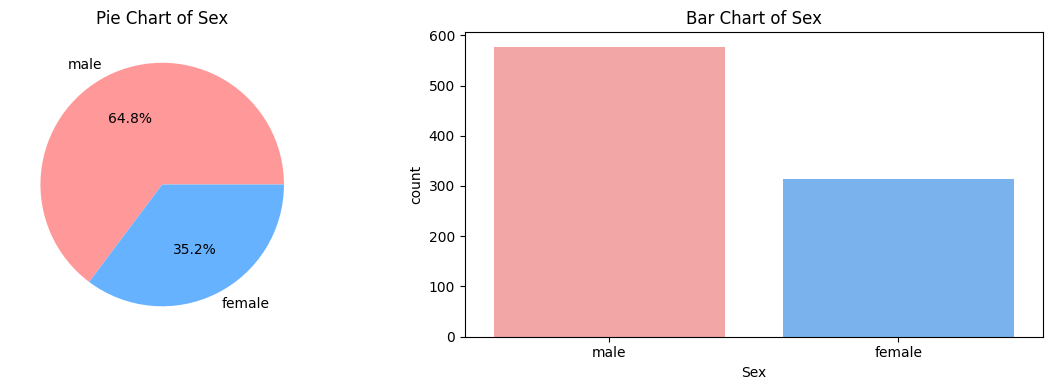

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
df_train0["Sex"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=colors[:2],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Sex")

# Bar chart
sns.countplot(
    x="Sex",
    data=df_train0,
    palette=colors[:2],
    ax=axes[1],
    hue="Sex",
    legend=False)
axes[1].set_title("Bar Chart of Sex")

plt.tight_layout()
plt.show()

The sex variable shows a clear imbalance, with about 65% of passengers being male and 35% female. This indicates that men were nearly twice as represented as women in the dataset, a demographic skew that is important to consider when analyzing outcomes. At this stage it only describes population composition, but it will later be relevant for assessing whether sex had an influence on survival.


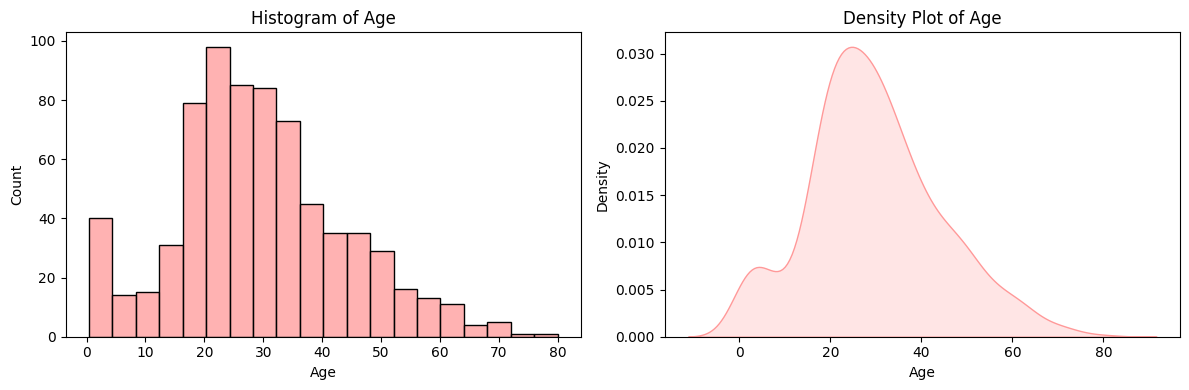

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(
    df_train0["Age"].dropna(),
    bins=20,
    kde=False,
    color=colors[0],
    ax=axes[0])
axes[0].set_title("Histogram of Age")

# Density plot
sns.kdeplot(
    df_train0["Age"].dropna(),
    fill=True,
    color=colors[0],
    ax=axes[1])
axes[1].set_title("Density Plot of Age")

plt.tight_layout()
plt.show()

The age distribution is right-skewed, with most passengers concentrated between 20 and 40 years old and fewer observations at higher ages. There is a small peak for very young children and a long tail extending into older ages above 60. This indicates that the dataset is dominated by young to middle-aged adults, while elderly passengers are underrepresented. Such skewness could impact modeling, as age may need transformation or binning to better capture differences across groups.

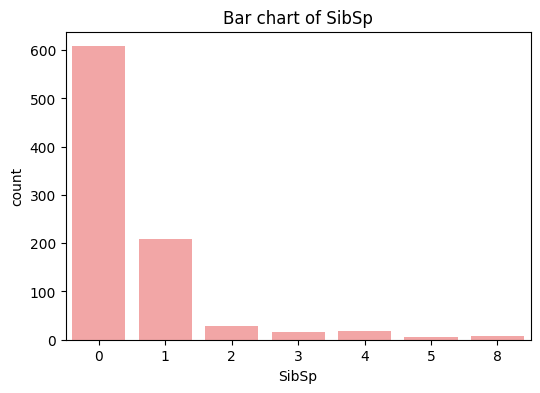

In [82]:
# Bar chart
plt.figure(figsize=(6, 4))
sns.countplot(
    x="SibSp",
    data=df_train0,
    color=colors[0])
plt.title("Bar chart of SibSp")
plt.show()

Most passengers had no siblings or spouses with them, and a smaller but visible group had one. Higher counts above two are rare and appear as outliers. This heavy concentration at the lower end suggests that the majority of passengers were traveling alone or with just one close family member, while large family groups were exceptional. Such skewness means SibSp may provide predictive value mainly through distinguishing between individuals traveling alone and those with at least one companion.

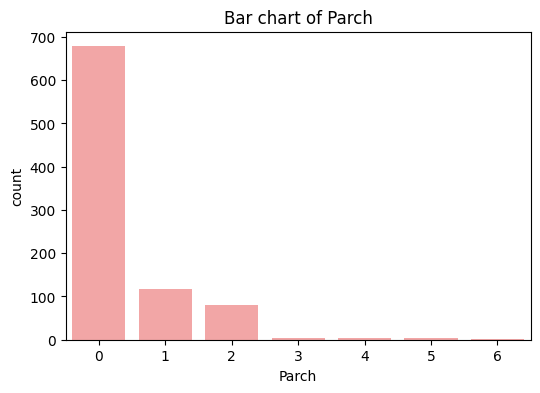

In [83]:
# Bar chart
plt.figure(figsize=(6, 4))
sns.countplot(
    x="Parch",
    data=df_train0,
    color=colors[0])
plt.title("Bar chart of Parch")
plt.show()

The majority of passengers had no immediate family with them, while smaller groups had one or two, and larger values above three are very rare. This indicates that most travelers were not accompanied by close family, with only a minority traveling in family units. The concentration at zero makes it similar in shape to SibSp, and its predictive contribution may come from distinguishing solo travelers from those with at least one parent or child on board.

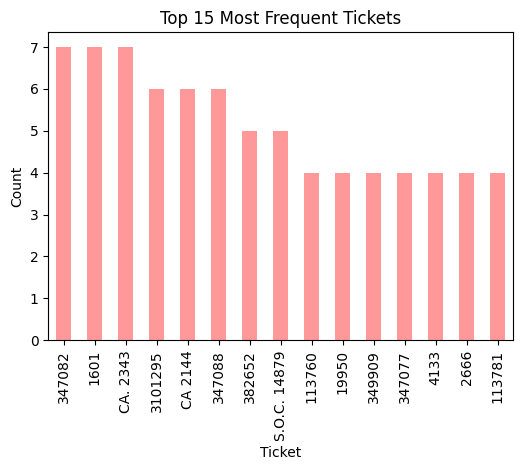

In [84]:
# Bar chart
plt.figure(figsize=(6, 4))
df_train0["Ticket"].value_counts().head(15).plot(
    kind="bar",
    color=colors[0])
plt.title("Top 15 Most Frequent Tickets")
plt.xlabel("Ticket")
plt.ylabel("Count")
plt.show()


The ticket variable obviously does not provide meaningful information for modeling. Its distribution is highly fragmented, with most values unique or appearing only a handful of times, making it effectively an identifier rather than a useful predictive feature.

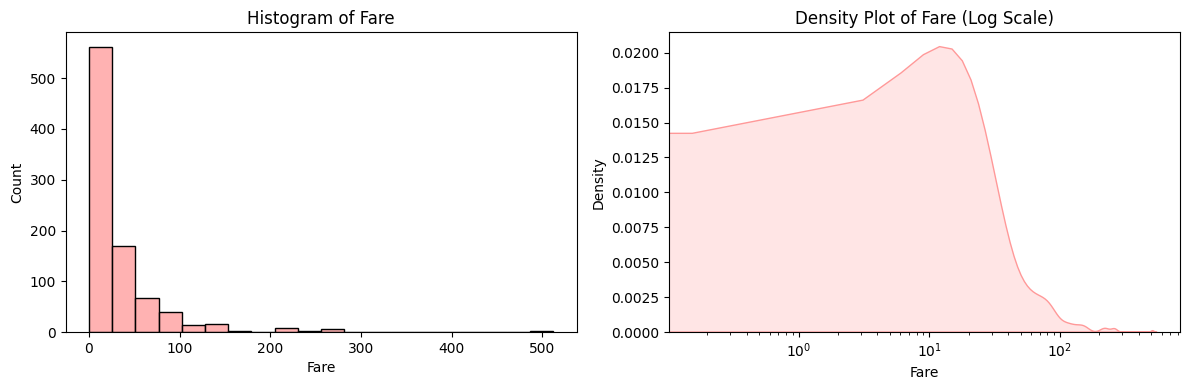

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(
    df_train0["Fare"],
    bins=20,
    kde=False,
    color=colors[0],
    ax=axes[0])
axes[0].set_title("Histogram of Fare")

# Density plot
sns.kdeplot(
    df_train0["Fare"],
    fill=True,
    color=colors[0],
    ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_title("Density Plot of Fare (Log Scale)")

plt.tight_layout()
plt.show()

The fare variable is highly right-skewed, with most passengers paying relatively low amounts and a few outliers with very high fares. Applying a log transformation makes the distribution more balanced and easier to model. The large spread in values suggests fare could be informative for distinguishing between passenger groups, potentially correlating with socioeconomic status or class.

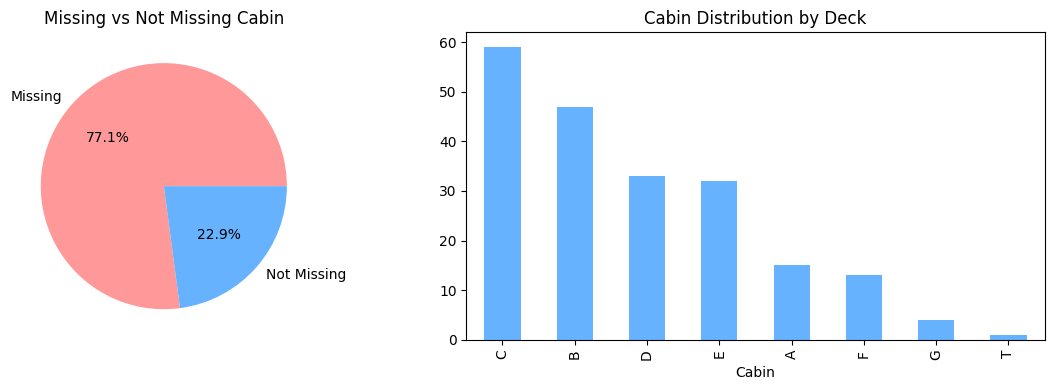

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
df_train0["Cabin"].isnull().value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Missing", "Not Missing"],
    colors=colors[:2],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Missing vs Not Missing Cabin")

# Bar chart
df_train0["Cabin"].dropna().str[0].value_counts().plot(
    kind="bar",
    color=colors[1],
    ax=axes[1])
axes[1].set_title("Cabin Distribution by Deck")

plt.tight_layout()
plt.show()

The cabin variable has a very high proportion of missing values, with over 77% of entries unavailable. Among the non-missing cases, the distribution across decks is uneven, with decks C and B most represented while others have very few observations. Because of the extensive missingness and the sparsity of certain categories, the variable is of limited direct use in modeling unless imputation or grouping strategies are applied.

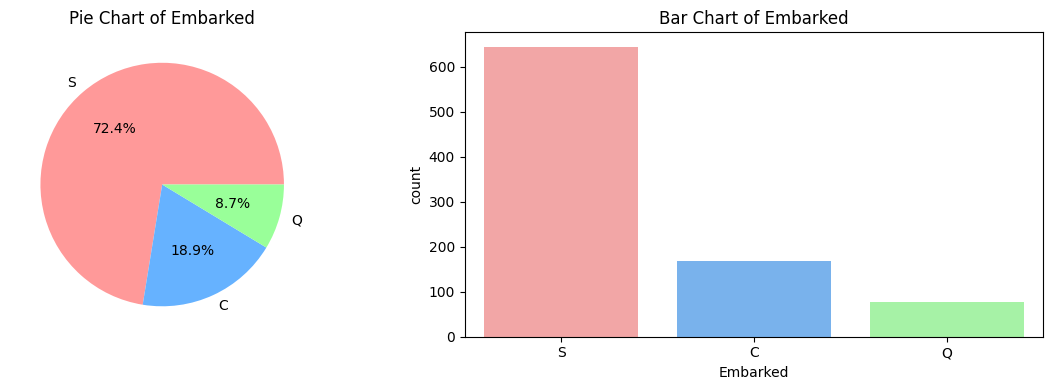

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
df_train0["Embarked"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=colors[:3],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Embarked")

# Bar chart
sns.countplot(
    x="Embarked",
    data=df_train0,
    palette=colors[:3],
    ax=axes[1],
    hue="Embarked",
    legend=False)
axes[1].set_title("Bar Chart of Embarked")

plt.tight_layout()
plt.show()


The embarked variable is dominated by port S, which accounts for more than 70% of passengers, while port C represents about 19% and port Q less than 10%. This strong imbalance shows that most passengers boarded at a single port, with the others much less represented. Although categorical, the skew in distribution may still provide useful information when combined with other features, but its predictive contribution alone is likely limited.

### 1.2 Multivariate Data Analysis

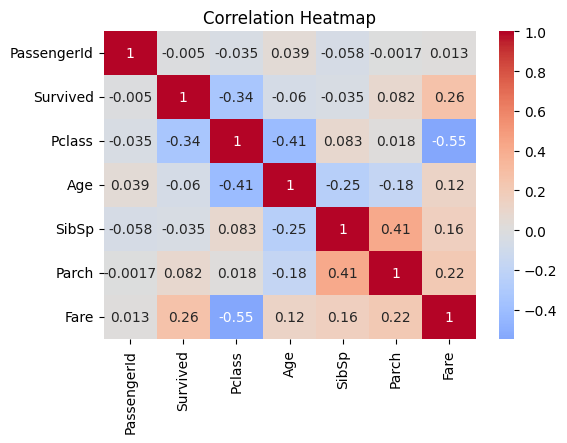

In [143]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
corr = df_train0.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

The correlation heatmap shows that survival has moderate negative correlation with passenger class and positive correlation with fare, suggesting socioeconomic status is linked to outcomes. SibSp and Parch are positively correlated with each other, reflecting their shared role in representing family size. Age shows weak correlations overall, while passenger ID behaves as expected like an identifier with no meaningful relation. The strongest relationship in the dataset is between class and fare, which are naturally tied, and this redundancy should be considered in feature selection

#### 1.2.1 Survival vs. predictors

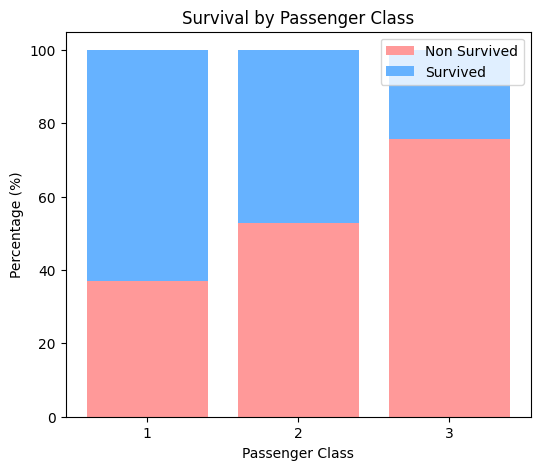

In [89]:
percent_df = (
    df_train0.groupby("Pclass")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="Pclass", columns="Survived", values="Percentage")

# Stacked bar chart of Survival by Passenger Class
plt.figure(figsize=(6, 4))
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])

plt.title("Survival by Passenger Class")
plt.ylabel("Percentage (%)")
plt.xlabel("Passenger Class")
plt.legend()
plt.show()

Survival rates vary strongly by passenger class. First-class passengers had the highest survival probability, with more than 60% surviving, while second-class survival was close to 50%. In contrast, third-class passengers had a much lower survival rate, with over 70% not surviving. This confirms that class was an important factor influencing outcomes and suggests it will be a key predictive feature in modeling survival.


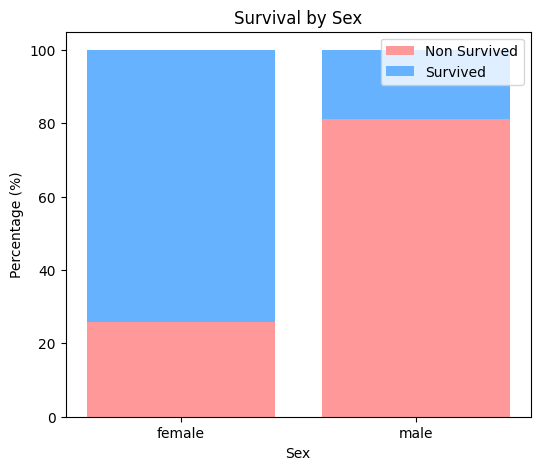

In [90]:
percent_df = (
    df_train0.groupby("Sex")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="Sex", columns="Survived", values="Percentage")

# Stacked bar chart of Survival by Sex
plt.figure(figsize=(6, 4))
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])

plt.title("Survival by Sex")
plt.ylabel("Percentage (%)")
plt.xlabel("Sex")
plt.legend()
plt.show()

The plot shows a stark difference in survival by sex. Around three quarters of women survived compared to only about one fifth of men. This highlights sex as a highly discriminative feature, with a much higher probability of survival for females. The imbalance strongly suggests that gender roles and evacuation priorities influenced outcomes, making this one of the most predictive variables in the dataset.

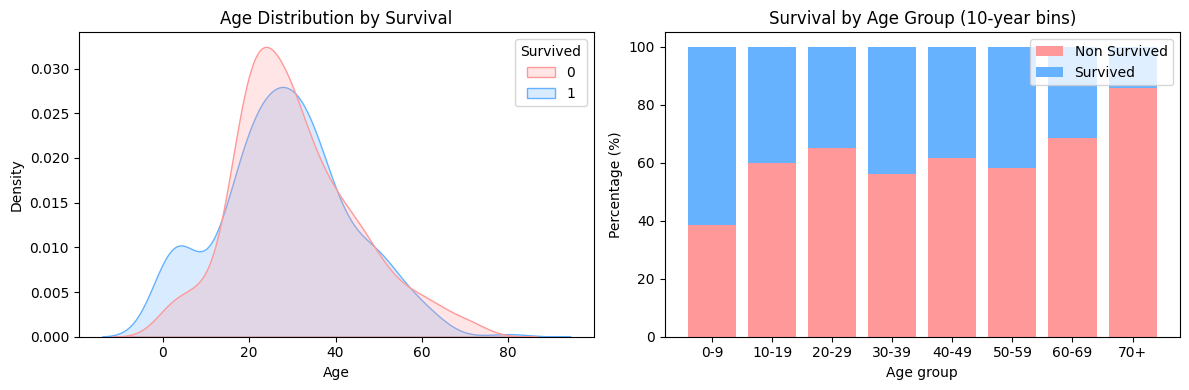

In [91]:
# 10 years Age bins
bins = list(range(0, 71, 10)) + [np.inf]
labels = [f"{i}-{i+9}" for i in range(0, 70, 10)] + ["70+"]
df_train0["AgeBin"] = pd.cut(df_train0["Age"], bins=bins, labels=labels, right=False)

percent_df = (
    df_train0.groupby("AgeBin", observed=False)["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="AgeBin", columns="Survived", values="Percentage")


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Density plot of Age Distribution by Survival
sns.kdeplot(
    x="Age",
    hue="Survived",
    data=df_train0,
    fill=True,
    common_norm=False,
    palette=colors[:2],
    ax=axes[0]
)
axes[0].set_title("Age Distribution by Survival")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Density")

# Stacked bar chart of Survival by Age Group (10-year bins)
axes[1].bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
axes[1].bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])
axes[1].set_title("Survival by Age Group (10-year bins)")
axes[1].set_ylabel("Percentage (%)")
axes[1].set_xlabel("Age group")
axes[1].legend()

plt.tight_layout()
plt.show()


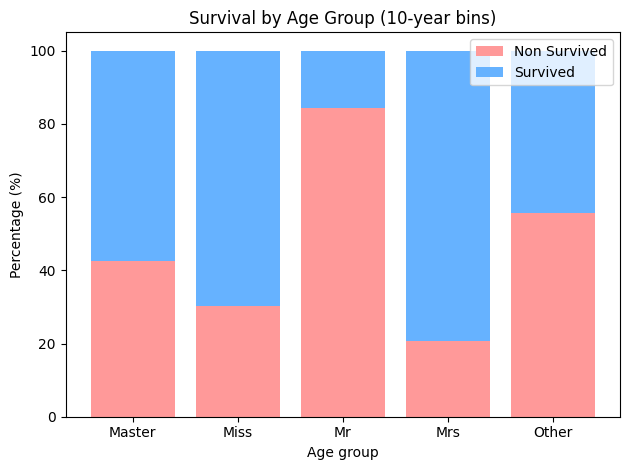

In [144]:
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])
plt.title("Survival by Age Group (10-year bins)")
plt.ylabel("Percentage (%)")
plt.xlabel("Age group")
plt.legend()

plt.tight_layout()
plt.show()

The left plot shows the age distribution by survival, where most passengers in both groups fall between 20 and 40 years, with children standing out as more likely to survive. The right plot with age bins confirms that survival rates were highest for those under 10, more balanced but lower for adults, and particularly low for older passengers. This indicates that age is an informative predictor, especially in distinguishing children and elderly from the main adult group.

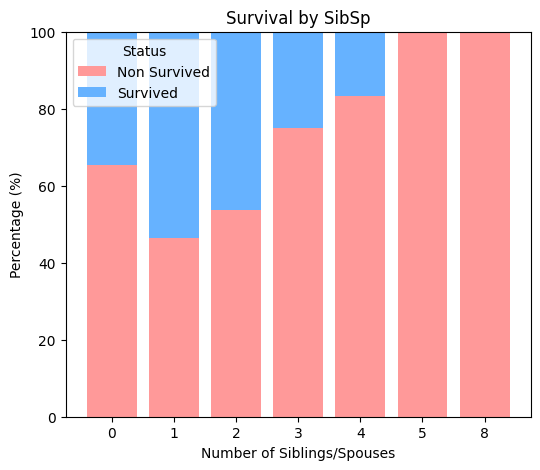

In [92]:
percent_df = (
    df_train0.groupby("SibSp")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="SibSp", columns="Survived", values="Percentage")

# Stacked bar chart of Survival by SibSp
plt.figure(figsize=(6, 4))
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])

plt.title("Survival by SibSp")
plt.ylabel("Percentage (%)")
plt.xlabel("Number of Siblings/Spouses")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

The plot shows that survival chances varied with the number of siblings or spouses aboard. Passengers traveling with one or two companions had relatively higher survival rates, while those traveling alone or in very large groups had lower survival. In particular, survival probability drops sharply for counts above three, where almost all passengers did not survive. This suggests that moderate family presence could be beneficial, but larger groups were strongly disadvantaged.

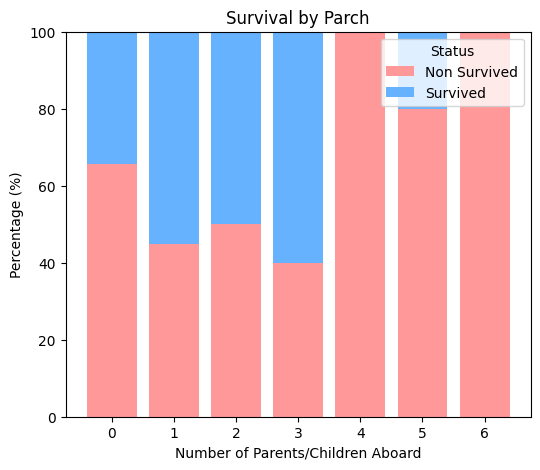

In [93]:
percent_df = (
    df_train0.groupby("Parch")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="Parch", columns="Survived", values="Percentage")

# Stacked bar chart of Survival by SibSp
plt.figure(figsize=(6, 4))
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])

plt.title("Survival by Parch")
plt.ylabel("Percentage (%)")
plt.xlabel("Number of Parents/Children Aboard")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

The plot indicates that survival was higher for passengers with one to three parents or children aboard compared to those traveling alone or with larger family groups. Individuals without family had a lower survival rate, while very large families (four or more) show almost no survival. This suggests that having a small family presence may have increased the chances of survival, but being in large groups was a disadvantage.


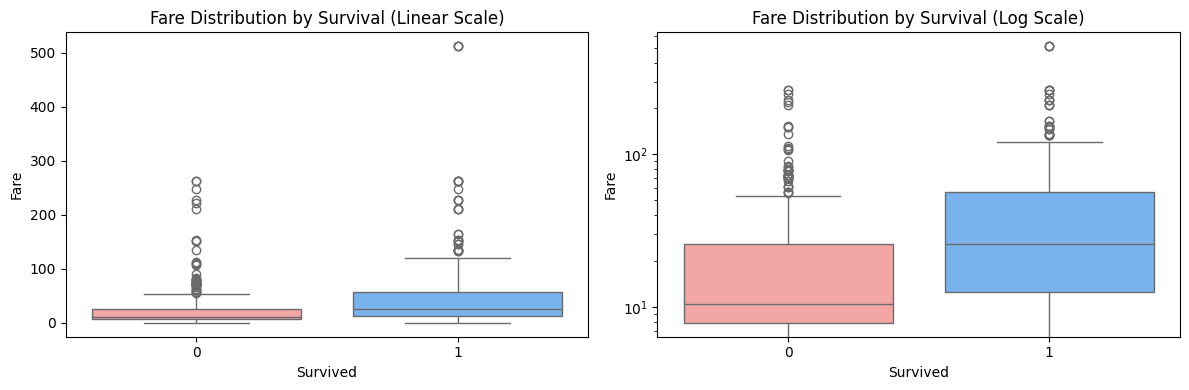

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot of Fare Distribution by Survival (Linear Scale)
sns.boxplot(
    x="Survived",
    y="Fare",
    data=df_train0,
    palette=colors[:2],
    hue="Survived",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Fare Distribution by Survival (Linear Scale)")
axes[0].set_ylabel("Fare")

# Boxplot of Fare Distribution by Survival (Log Scale)
sns.boxplot(
    x="Survived",
    y="Fare",
    data=df_train0,
    palette=colors[:2],
    hue="Survived",
    legend=False,
    ax=axes[1]
)
axes[1].set_yscale("log")
axes[1].set_title("Fare Distribution by Survival (Log Scale)")
axes[1].set_ylabel("Fare")

plt.tight_layout()
plt.show()


The side-by-side boxplots confirm that fare is an important discriminative feature. On the linear scale the differences are masked by a few extreme outliers, but the log scale makes the pattern clearer: survivors generally paid higher fares, with both the median and the interquartile range shifted upward compared to non-survivors. This supports the interpretation that fare, as a proxy for passenger class or socioeconomic status, strongly influenced survival probability.

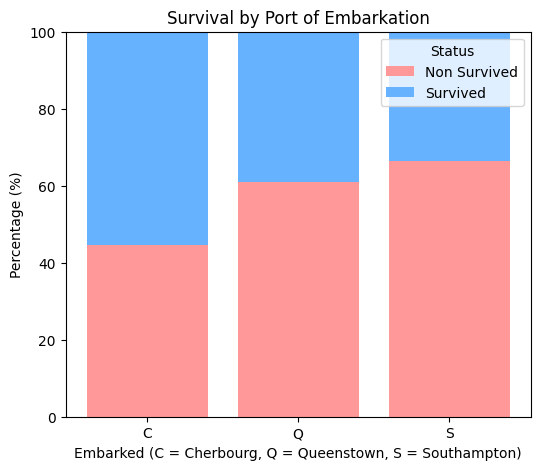

In [95]:
percent_df = (
    df_train0.groupby("Embarked")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="Embarked", columns="Survived", values="Percentage")

# Stacked bar chart of Survival by Port of Embarkation
plt.figure(figsize=(6, 4))
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])

plt.title("Survival by Port of Embarkation")
plt.ylabel("Percentage (%)")
plt.xlabel("Embarked (C = Cherbourg, Q = Queenstown, S = Southampton)")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

The chart shows clear differences in survival depending on the port of embarkation. Passengers from Cherbourg had the highest survival rate, with more than half surviving. Those from Queenstown had a lower survival probability, while passengers from Southampton had the lowest, with about two-thirds not surviving. This suggests that port of embarkation carries useful information, likely reflecting differences in passenger composition such as class distribution or socioeconomic status.

#### 1.2.2 Larger scope analysis

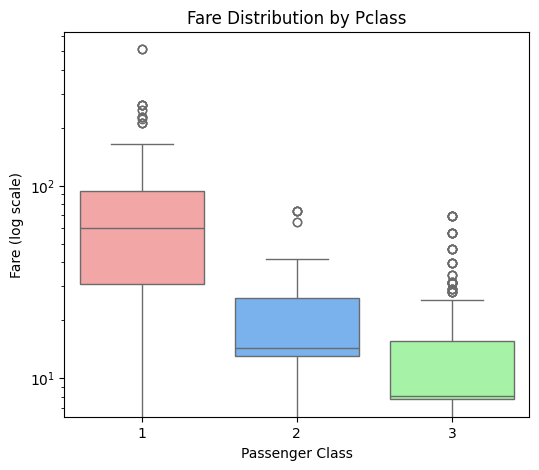

In [96]:
# Boxplot of Fare Distribution by Pclass
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="Pclass",
    y="Fare",
    data=df_train0,
    palette=colors[:3],
    hue="Pclass",
    legend=False
)
plt.yscale("log")
plt.title("Fare Distribution by Pclass")
plt.ylabel("Fare (log scale)")
plt.xlabel("Passenger Class")
plt.show()


The boxplot shows a clear separation of fare distributions across passenger classes. First-class passengers paid the highest fares with a wide spread and many high-value outliers, second-class fares were lower and more concentrated, while third-class passengers had the lowest fares overall. The log scale makes the differences more visible and confirms a strong association between class and fare, reflecting their redundancy as socioeconomic indicators.

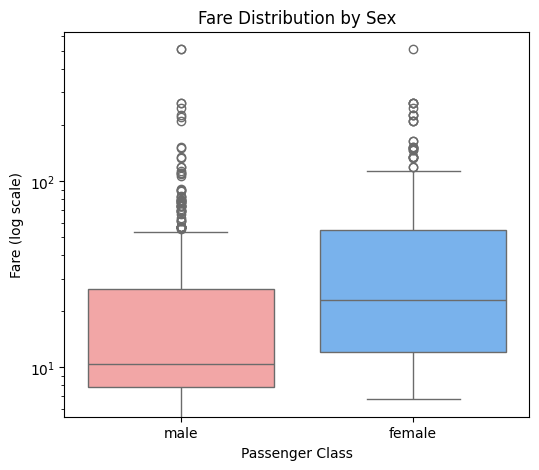

In [97]:
# Boxplot of Fare Distribution by Sex
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="Sex",
    y="Fare",
    data=df_train0,
    palette=colors[:2],
    hue="Sex",
    legend=False
)
plt.yscale("log")
plt.title("Fare Distribution by Sex")
plt.ylabel("Fare (log scale)")
plt.xlabel("Passenger Class")
plt.show()

Females generally paid higher fares than males. The median fare for women is clearly above that of men, and their distribution is more spread out across higher values. Men are concentrated at lower fares, with relatively few paying at the top end. Since fare is strongly linked to passenger class and socioeconomic status, this suggests that women in the dataset were more represented in higher classes, which in turn is associated with better survival chances.

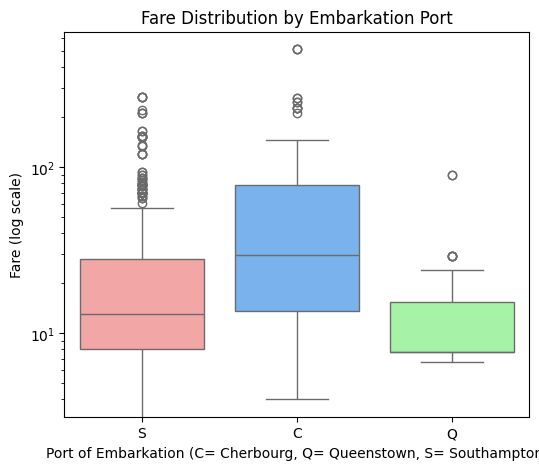

In [98]:
# Boxplot of Fare Distribution by Embarkation Port
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="Embarked",
    y="Fare",
    data=df_train0,
    palette=colors[:3],
    hue="Embarked",
    legend=False
)
plt.yscale("log")
plt.title("Fare Distribution by Embarkation Port")
plt.ylabel("Fare (log scale)")
plt.xlabel("Port of Embarkation (C= Cherbourg, Q= Queenstown, S= Southampton)")
plt.show()


The boxplot shows that fares varied notably by port of embarkation. Passengers boarding at Cherbourg generally paid the highest fares with a wide spread, Southampton passengers paid lower fares with many concentrated at the bottom range, and Queenstown passengers paid the lowest fares overall. This pattern suggests that the port of embarkation is indirectly capturing differences in passenger composition, such as class and socioeconomic background.

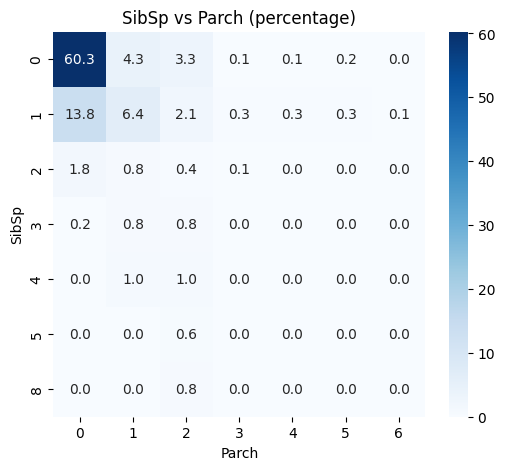

In [99]:
# heatmap of SibSp vs Parch (percentage)
cross_tab = pd.crosstab(df_train0["SibSp"], df_train0["Parch"])
cross_tab_pct = cross_tab.div(cross_tab.sum().sum()).mul(100)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cross_tab_pct,
    cmap="Blues",
    annot=True,
    fmt=".1f")
plt.title("SibSp vs Parch (percentage)")
plt.xlabel("Parch")
plt.ylabel("SibSp")
plt.show()


The majority of passengers, over 60%, had no siblings/spouses and no parents/children aboard. About 14% had one sibling/spouse but no parents/children, and smaller groups appear in low-frequency combinations such as one or two relatives of each type. Larger families are rare and represent less than 1% each.

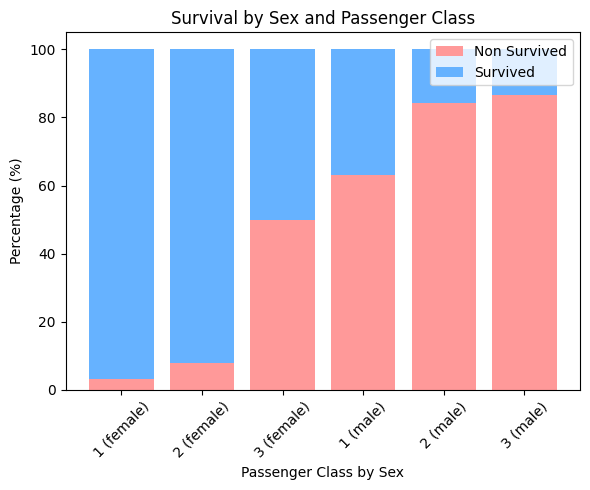

In [100]:
percent_df = (
    df_train0.groupby(["Sex", "Pclass"])["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot_table(
    index=["Sex", "Pclass"], columns="Survived", values="Percentage"
)
pivot_df = pivot_df.reset_index()

# Stacked bar chart of Survival by Sex and Passenger Class
plt.figure(figsize=(6, 4))
for sex in pivot_df["Sex"].unique():
    subset = pivot_df[pivot_df["Sex"] == sex]
    plt.bar(
        subset["Pclass"].astype(str) + " (" + sex + ")",
        subset[0],
        label="Non Survived" if sex == "male" else "",
        color=colors[0]
    )
    plt.bar(
        subset["Pclass"].astype(str) + " (" + sex + ")",
        subset[1],
        bottom=subset[0],
        label="Survived" if sex == "male" else "",
        color=colors[1]
    )

plt.title("Survival by Sex and Passenger Class")
plt.ylabel("Percentage (%)")
plt.xlabel("Passenger Class by Sex")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Females in first and second class had extremely high survival rates, with survival exceeding 90%. Third-class females survived at lower rates, but still much higher than men. For males, the trend is the opposite: survival was poor across all classes, with first-class men doing somewhat better than second- and third-class, but still with the majority not surviving.

## 2 Data Cleaning

### 2.1 Missing Values

In [101]:
total = df_train0.isnull().sum().sort_values(ascending=False)
percent = (df_train0.isnull().sum() / len(df_train0)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
Cabin,687,0.771044
Age,177,0.198653
AgeBin,177,0.198653
Embarked,2,0.002245
Survived,0,0.000000
PassengerId,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000
SibSp,0,0.000000


In [102]:
df_train0 = df_train0.drop(columns=["Cabin"])

Dropping the Cabin variable is reasonable because more than 77% of its values are missing. With such a high level of missingness, any imputation strategy would introduce a large amount of noise and uncertainty. While cabin information could in principle contain predictive value (e.g., deck location), the incompleteness makes it unreliable. Removing the column ensures the model does not learn spurious patterns from heavily imputed data.

In [103]:
df_train0.groupby(["Pclass", "Sex"])["Age"].median().unstack()

Sex,female,male
Pclass,,
1,35.0,40.0
2,28.0,30.0
3,21.5,25.0


In [104]:
df_train0["Age"] = df_train0.groupby(["Pclass", "Sex"])["Age"].transform(
    lambda x: x.fillna(x.median())
)
df_train0["AgeBin"] = pd.cut(df_train0["Age"], bins=bins, labels=labels, right=False)

For the Age variable, imputing with the overall median would ignore heterogeneity in the dataset. A more refined approach is to impute within subgroups defined by passenger class and sex, since these characteristics are likely correlated with age distributions. For example, first-class passengers tended to be older, and women might have different age profiles than men. Filling missing values with the median of each (Pclass, Sex) group leverages available structure in the data and produces more realistic estimates. By updating AgeBin after imputation, the categorical representation of age remains aligned with the cleaned data and is ready for use in subsequent visualizations and modeling.

In [105]:
mode_embarked = df_train0["Embarked"].mode()[0]
df_train0["Embarked"] = df_train0["Embarked"].fillna(mode_embarked)

The Embarked variable has very few missing values, only two cases. In this situation, imputing with the mode is the simplest and most consistent approach. Since the vast majority of passengers embarked from Southampton, filling the missing entries with the most frequent category preserves the integrity of the dataset without distorting distributions.

In [106]:
# Final check: ensure no missing values remain
total = df_train0.isnull().sum().sort_values(ascending=False)
percent = (df_train0.isnull().sum() / len(df_train0)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0




---


The same transformations are now applied to the test dataset.

In [107]:
# Check missing values in df_test
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum() / len(df_test)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Name,0,0.000000
Pclass,0,0.000000
PassengerId,0,0.000000
Sex,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Ticket,0,0.000000


In [108]:
# 1. Drop Cabin Column
df_test = df_test.drop(columns=["Cabin"])

# 2. Imputation of median Age + Age Bin
df_test["Age"] = df_test.groupby(["Pclass", "Sex"])["Age"].transform(
    lambda x: x.fillna(x.median())
)
df_test["AgeBin"] = pd.cut(df_test["Age"], bins=bins, labels=labels, right=False)

# 3. Imputation of mode Embraked
mode_embarked = df_test["Embarked"].mode()[0]
df_test["Embarked"] = df_test["Embarked"].fillna(mode_embarked)

# 4. Imputation of median Fare
df_test["Fare"] = df_test.groupby(["Pclass", "Sex"])["Fare"] .transform(
    lambda x: x.fillna(x.median()
    ))

# Final check missing values in df_test
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum() / len(df_test)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
PassengerId,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0
Embarked,0,0.0


### 2.2 Outliers

In [109]:
# Function to find outliers with the IQR rule
def iqr_outliers(s: pd.Series, k: float = 1.5):
    s_clean = s.dropna()
    q1, q3 = s_clean.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    mask = s.lt(low) | s.gt(high)
    return mask, low, high

# Compute aligned masks and outlier tables for Age and Fare.
age_mask, age_low, age_high   = iqr_outliers(df_train0["Age"])
fare_mask, fare_low, fare_high = iqr_outliers(df_train0["Fare"])

# Outlier subsets (kept for inspection; not removed from the dataset).
age_out = df_train0.loc[age_mask,  ["PassengerId","Survived","Pclass","Sex","Age","Embarked","Fare"]]
fare_out = df_train0.loc[fare_mask, ["PassengerId","Survived","Pclass","Sex","Age","Embarked","Fare"]]

# Build a compact summary as the last expression (so it displays without prints).
n_age  = df_train0["Age"].notna().sum()
n_fare = df_train0["Fare"].notna().sum()

summary = pd.DataFrame(
    {
        "n_outliers": [
            len(age_out),
            len(fare_out),
        ],
        "share_outliers": [
            len(age_out) / n_age if n_age else 0.0,
            len(fare_out) / n_fare if n_fare else 0.0,
        ],
        "lower_bound": [age_low,  fare_low],
        "upper_bound": [age_high, fare_high],
    },
    index=["Age", "Fare"],
)

In [110]:
summary

,n_outliers,share_outliers,lower_bound,upper_bound
Age,33,0.037037,-0.250,57.7500
Fare,116,0.130191,-26.724,65.6344


In [111]:
fare_out.groupby("Pclass").size().sort_values(ascending=False).head(3).rename("Count by Pclass")

,Count by Pclass
Pclass,
1,104
3,7
2,5


Fare outliers are mostly concentrated in 1st class which is consistent with luxury tickets. As previously seen, their survival rate is higher than the rest, suggesting that extreme fares reflect socio-economic advantage rather than data errors.

In [112]:
age_out.groupby("Pclass").size().sort_values(ascending=False).head(3).rename("Count by Pclass")

,Count by Pclass
Pclass,
1,22
3,6
2,5


Age outliers are a small set of very old passengers present across classes; they look plausible. Children show higher survival, while very old passengers tend to have lower survival.

## 3 Feature Engineering
In this step the dataset is enriched through a series of transformations designed to turn raw attributes into features more suitable for modeling.

In [113]:
# make a working copy
df_train = df_train0.copy()

### 3.1 Family Group

Family information is consolidated by combining the number of siblings/spouses and parents/children into a total family size, which is then categorized into groups such as Alone, Small, Medium, and Large to capture different survival dynamics linked to family composition.

In [114]:
# Family size
df_train["Family size"] = df_train0["SibSp"] + df_train0["Parch"]

# Categorize Family size into Family Group
cond = [
    df_train["Family size"] == 0,
    df_train["Family size"].between(1, 3),
    df_train["Family size"].between(4, 6),
    df_train["Family size"].between(7, 11)
]
choice = ["Alone", "Small", "Medium", "Large"]

df_train["Family group"] = np.select(cond, choice, default="Other")
df_train["Family group"] = pd.Categorical(
    df_train["Family group"],
    categories=["Alone", "Small", "Medium", "Large"],
    ordered=True,
)

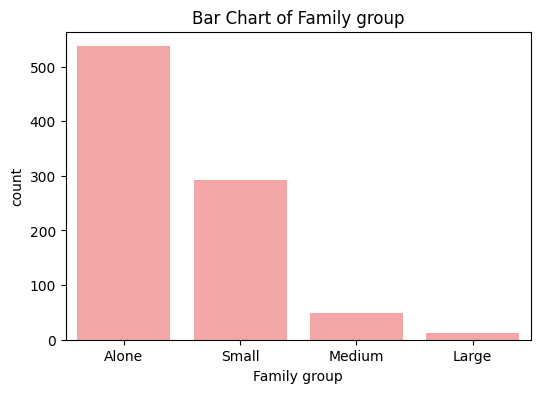

In [115]:
# Bar Chart of Family group
plt.figure(figsize=(6, 4))
sns.countplot(
    x="Family group",
    data=df_train,
    color=colors[0],
    legend=False)
plt.title("Bar Chart of Family group")
plt.show()

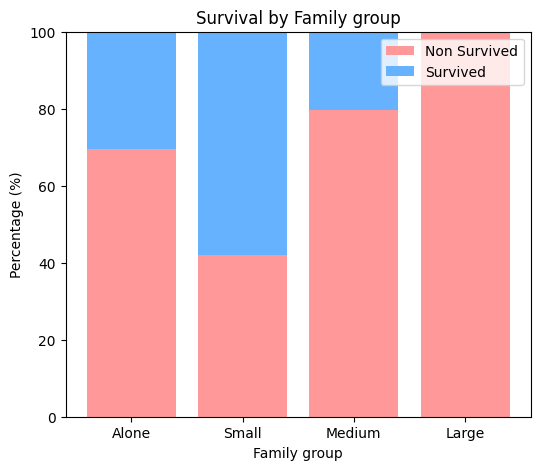

In [116]:
percent_df = (
    df_train.groupby("Family group", observed=False)["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="Family group", columns="Survived", values="Percentage")

# Stacked bar chart of Survival by Family group
plt.figure(figsize=(6, 4))
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])

plt.title("Survival by Family group")
plt.ylabel("Percentage (%)")
plt.xlabel("Family group")
plt.legend()
plt.show()

### 3.2 Title Status

Social status cues are extracted from the passenger’s name by isolating the title and retaining only the most frequent categories, while rare titles are grouped together.

In [117]:
# Title extraction
df_train["Title"] = df_train0["Name"].apply(
    lambda x: x.split(",")[1].split(".")[0].strip()
)
df_train["Title"] = df_train["Title"].apply(
    lambda t: t if t in ("Mr", "Mrs", "Miss", "Master") else "Other"
)

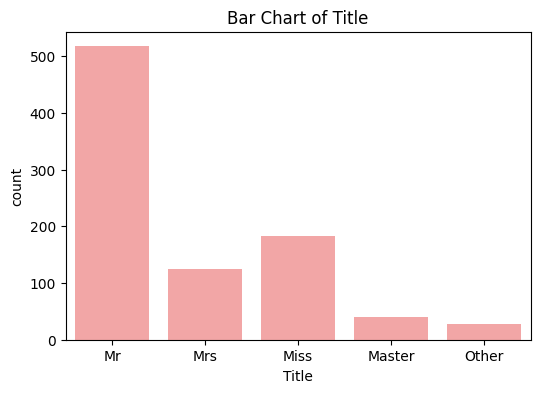

In [118]:
# Bar Chart of Title
plt.figure(figsize=(6, 4))
sns.countplot(
    x="Title",
    data=df_train,
    color=colors[0],
    legend=False)
plt.title("Bar Chart of Title")
plt.show()

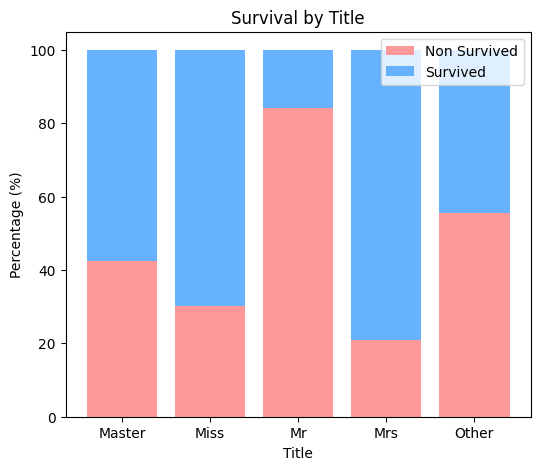

In [119]:
percent_df = (
    df_train.groupby("Title", observed=False)["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)
pivot_df = percent_df.pivot(index="Title", columns="Survived", values="Percentage")

# Stacked Bar Chart of Survival by Title
plt.figure(figsize=(6, 4))
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[0],
    label="Non Survived",
    color=colors[0])
plt.bar(
    pivot_df.index.astype(str),
    pivot_df[1],
    bottom=pivot_df[0],
    label="Survived",
    color=colors[1])

plt.title("Survival by Title")
plt.ylabel("Percentage (%)")
plt.xlabel("Title")
plt.legend()
plt.show()

### 3.3 Standardized Log Fare

Fare values, which are heavily skewed, are transformed with a logarithm and standardized so that they can be compared more directly to other features.

In [120]:
# Standardized Log Fare
df_train["LogFare"] = np.log1p(df_train0["Fare"])
scaler = StandardScaler()
df_train["LogFare"] = scaler.fit_transform(df_train[["LogFare"]])

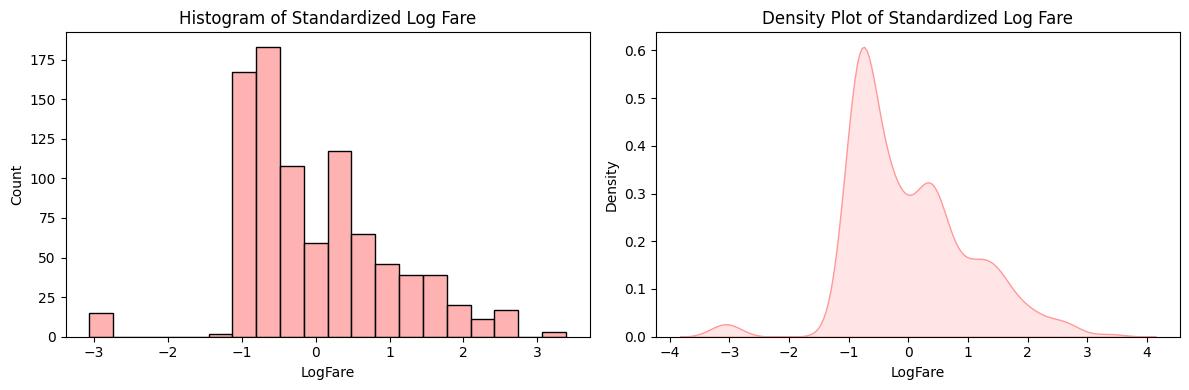

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of Standardized Log Fare
sns.histplot(
    df_train["LogFare"],
    bins=20,
    kde=False,
    color=colors[0],
    ax=axes[0])
axes[0].set_title("Histogram of Standardized Log Fare")

# Density plot of Standardized Log Fare
sns.kdeplot(
    df_train["LogFare"],
    fill=True,
    color=colors[0],
    ax=axes[1])
axes[1].set_title("Density Plot of Standardized Log Fare")

plt.tight_layout()
plt.show()

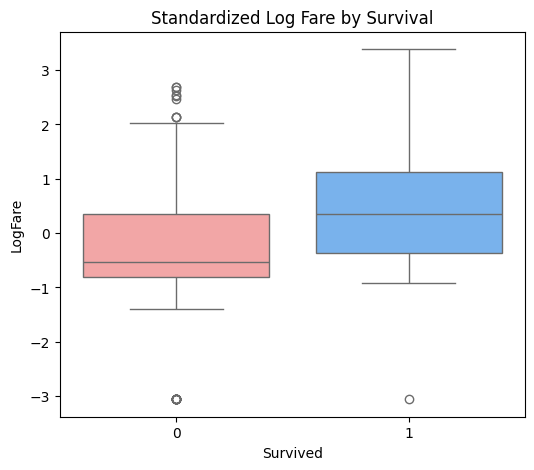

In [122]:
# Boxplot of LogFare Distribution by Survival
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="Survived",
    y="LogFare",
    data=df_train,
    palette=colors[:2],
    hue="Survived",
    legend=False
)
plt.title("Standardized Log Fare by Survival")
plt.ylabel("LogFare")
plt.show()

### 3.4 Sex × Pclass interaction

In [123]:
# Sex × Pclass interaction
df_train["Sex_Pclass"] = df_train0["Sex"].astype(str) + "_" + df_train0["Pclass"].astype(str)

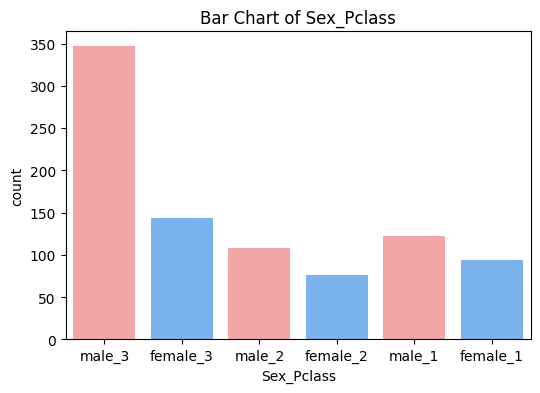

In [124]:
# Bar Chart of Sex_Pclass
plt.figure(figsize=(6, 4))
sns.countplot(
    x="Sex_Pclass",
    data=df_train,
    palette=colors[:2],
    hue="Sex",
    legend=False,
    order = ["male_3", "female_3", "male_2", "female_2", "male_1", "female_1"])
plt.title("Bar Chart of Sex_Pclass")
plt.show()

### 3.5 Age Bin

Since age showed a clear and meaningful relationship with survival in the exploratory analysis, we kept the binned age variable to capture these group-level patterns.  
This transformation simplifies interpretation and allows models to better leverage non-linear effects across age categories.


In [125]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived_label,AgeBin,Family size,Family group,Title,LogFare,Sex_Pclass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Did not survive,20-29,1,Small,Mr,-0.879741,male_3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Survived,30-39,1,Small,Mrs,1.361220,female_1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Survived,20-29,0,Alone,Miss,-0.798540,female_3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Survived,30-39,1,Small,Mrs,1.062038,female_1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Did not survive,30-39,0,Alone,Mr,-0.784179,male_3




---


The same transformations are now applied to the test dataset.

In [126]:
# Family size
df_test["Family size"] = df_test["SibSp"] + df_test["Parch"]
cond = [
    df_test["Family size"].isin([0, 1]),
    df_test["Family size"].isin([2, 3, 4]),
    df_test["Family size"].isin([5, 6]),
    df_test["Family size"].isin([7, 8, 11]),
]
choice = ["Alone", "Small", "Medium", "Large"]

df_test["Family group"] = np.select(cond, choice, default="Other")
df_test["Family group"] = pd.Categorical(
    df_test["Family group"],
    categories=["Alone", "Small", "Medium", "Large", "Other"],
    ordered=True,
)

# Title extraction
df_test["Title"] = df_test["Name"].apply(
    lambda x: x.split(",")[1].split(".")[0].strip()
)
df_test["Title"] = df_test["Title"].apply(
    lambda t: t if t in ("Mr", "Mrs", "Miss", "Master") else "Other"
)

# Log + Standardize Fare
df_test["LogFare"] = np.log1p(df_test["Fare"])
scaler = StandardScaler()
df_test["LogFare"] = scaler.fit_transform(df_test[["LogFare"]])

# Sex × Pclass interaction
df_test["Sex_Pclass"] = df_test["Sex"].astype(str) + "_" + df_test["Pclass"].astype(str)


## 4 Model training

In [127]:
df_results = pd.DataFrame({
    "Model": pd.Series(dtype="str"),
    "Accuracy": pd.Series(dtype="float"),
    "Precision": pd.Series(dtype="float"),
    "Recall": pd.Series(dtype="float"),
    "F1": pd.Series(dtype="float"),
    "AUC": pd.Series(dtype="float"),
    "TN": pd.Series(dtype="int"),
    "FP": pd.Series(dtype="int"),
    "FN": pd.Series(dtype="int"),
    "TP": pd.Series(dtype="int")
})

df_rocs = pd.DataFrame({
    "Model": pd.Series(dtype="str"),
    "FPR": pd.Series(dtype="float"),
    "TPR": pd.Series(dtype="float"),
})


The Linear Regression and Naïve Bayes models are trained on two distinct representations of the dataset, each tailored to the assumptions and strengths of the respective algorithm.

* **Linear Regression** is sensitive to multicollinearity, as correlated features can make coefficient estimates unstable and difficult to interpret.  
  Therefore, categorical variables are one-hot encoded with one reference category dropped to avoid perfect linear dependence.  
  Additionally, the gender-class interaction term is included to capture non-additive effects that a purely linear model would otherwise miss, reflecting complex patterns in survival outcomes.

* **Naïve Bayes** assumes conditional independence among features given the target class, which makes it inherently robust to multicollinearity.  
  For this reason, all one-hot encoded categories are retained, i.e. no baseline level is dropped, since the model treats each feature independently rather than as part of a linear combination.  
  Two variants are trained on different representations of the same data:  
  – **BernoulliNB**, where all features are binarized to model the presence or absence of traits.  
  – **GaussianNB**, where all features are kept continuous and standardized to model their magnitudes.  
  Because feature interactions contradict the independence assumption, interaction terms are not included in the Naïve Bayes setup.

### 4.1 Linear Regression

For Linear regression, categorical variables including class, port of embarkation, title, age groups and family group are expanded into dummy variables, and boolean types are converted to integers. The result is a fully numerical dataset in which the main sources of demographic, social and economic variation have been encoded in a consistent and interpretable way.

In [128]:
# Make a working copy
df_train_lr = df_train.copy()

# One-hot encoding for categorical features (including Pclass)
df_train_lr = pd.get_dummies(
    df_train_lr,
    columns=["Sex", "Embarked", "Title", "Pclass","AgeBin","Family group", "Sex_Pclass"],
    drop_first=True  # avoid collinearity
)

# Convert all boolean columns to int (0/1)
bool_cols = df_train_lr.select_dtypes(include=["bool"]).columns
df_train_lr[bool_cols] = df_train_lr[bool_cols].astype(int)

# Define features (drop IDs and non-useful columns)
X = df_train_lr.drop(columns=["Age", "PassengerId", "Name", "Ticket", "Survived","SibSp","Parch","Survived_label","Family size", "Fare"])

# Target
y = df_train_lr["Survived"]

print("Final feature set:", X.columns.tolist())

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Final feature set: ['LogFare', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Pclass_2', 'Pclass_3', 'AgeBin_10-19', 'AgeBin_20-29', 'AgeBin_30-39', 'AgeBin_40-49', 'AgeBin_50-59', 'AgeBin_60-69', 'AgeBin_70+', 'Family group_Small', 'Family group_Medium', 'Family group_Large', 'Sex_Pclass_female_2', 'Sex_Pclass_female_3', 'Sex_Pclass_male_1', 'Sex_Pclass_male_2', 'Sex_Pclass_male_3']


In [129]:
X.head()

,LogFare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Pclass_2,Pclass_3,...,AgeBin_60-69,AgeBin_70+,Family group_Small,Family group_Medium,Family group_Large,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3
0,-0.879741,1,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,1.361220,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-0.798540,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1.062038,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-0.784179,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [130]:
# One-hot encoding for categorical features (including Pclass)
df_test = pd.get_dummies(
    df_test,
    columns=["Sex", "Embarked", "Title", "Pclass","AgeBin","Family group", "Sex_Pclass"],
    drop_first=True  # avoid collinearity
)

# Convert all boolean columns to int (0/1)
bool_cols = df_test.select_dtypes(include=["bool"]).columns
df_test[bool_cols] = df_test[bool_cols].astype(int)

In [131]:
# 1 Cross-validated predictions and performance metrics

# Define and evaluate Linear Regression using cross_val_predict
l_reg = LinearRegression()
y_pred_cont_oof = cross_val_predict(l_reg, X, y, cv=cv, method="predict", n_jobs=-1)

# Convert continuous predictions to binary outputs using a 0.5 threshold
y_pred_oof = (y_pred_cont_oof >= 0.5).astype(int)

# Compute standard evaluation metrics
acc  = accuracy_score(y, y_pred_oof)
prec = precision_score(y, y_pred_oof)
rec  = recall_score(y, y_pred_oof)
f1   = f1_score(y, y_pred_oof)
cm = confusion_matrix(y, y_pred_oof)
tn, fp, fn, tp = cm.ravel()
fpr, tpr, thresholds = roc_curve(y, y_pred_cont_oof)
auc = roc_auc_score(y, y_pred_cont_oof)

# Store results in df_results and df_rocs
row_results = pd.DataFrame([{
    "Model": "Linear Regression",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "AUC": auc,
    "TN": tn,
    "FP": fp,
    "FN": fn,
    "TP": tp
}])

row_roc = pd.DataFrame([{
    "Model": "Linear Regression",
    "FPR": fpr,
    "TPR": tpr
}])

df_results = pd.concat([df_results, row_results], ignore_index=True)
df_rocs    = pd.concat([df_rocs, row_roc], ignore_index=True)

# 2 Coefficient estimation linked to the same cross-validation
coefs = []
intercepts = []
per_fold = []

# Iterate over the same StratifiedKFold splits used in cross_val_predict
for fold_idx, (tr, te) in enumerate(cv.split(X, y)):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]

    # Fit Linear Regression on training folds only
    lr = LinearRegression()
    lr.fit(X_tr, y_tr)

    # Collect coefficients and intercept for each fold
    coefs.append(lr.coef_)
    intercepts.append(lr.intercept_)

# Aggregate coefficients across folds
coef_mean = np.mean(coefs, axis=0)
coef_std  = np.std(coefs, axis=0)
intercept_mean = float(np.mean(intercepts))
intercept_std  = float(np.std(intercepts))

coef_cv_df = pd.DataFrame({
    "Feature": X.columns,
    "Coef_mean": coef_mean,
    "Coef_std": coef_std
})

#### 4.1.3. Lasso Regression (L1 regularization)

In [132]:
# Define search space for regularization strength
alphas = np.logspace(-4, 2, 30)
results_l1 = []

# Cross-validated evaluation for each alpha
for alpha in alphas:
    l1_reg = Lasso(alpha=alpha, random_state=42, max_iter=5000)

    # Perform cross-validated predictions using the same StratifiedKFold splits
    y_pred_cont_oof = cross_val_predict(l1_reg, X, y, cv=cv, method="predict", n_jobs=-1)

    # Convert continuous predictions to binary outputs using a 0.5 threshold
    y_pred_oof = (y_pred_cont_oof >= 0.5).astype(int)

    # Compute standard evaluation metrics
    acc  = accuracy_score(y, y_pred_oof)
    prec = precision_score(y, y_pred_oof, zero_division=0)
    rec  = recall_score(y, y_pred_oof, zero_division=0)
    f1   = f1_score(y, y_pred_oof, zero_division=0)
    cm = confusion_matrix(y, y_pred_oof)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, thresholds = roc_curve(y, y_pred_cont_oof)
    auc = roc_auc_score(y, y_pred_cont_oof)

    # Store all metrics and ROC data in the results list
    results_l1.append({
      "alpha": alpha,
      "Accuracy": acc,
      "Precision": prec,
      "Recall": rec,
      "F1": f1,
      "AUC": auc,
      "TN": tn,
      "FP": fp,
      "FN": fn,
      "TP": tp,
      "FPR": fpr,
       "TPR": tpr
    })

df_l1 = pd.DataFrame(results_l1)


# Highest F1 model selection
best_row = df_l1.loc[df_l1["F1"].idxmax()]
best_alpha = best_row["alpha"]

# Extract corresponding metrics and ROC data for the best-performing model
row_results = pd.DataFrame([{
    "Model": f"L1 Regression (Alpha={round(best_alpha,3)})",
    "Accuracy": best_row["Accuracy"],
    "Precision": best_row["Precision"],
    "Recall": best_row["Recall"],
    "F1": best_row["F1"],
    "AUC": best_row["AUC"],
    "TN": best_row["TN"],
    "FP": best_row["FP"],
    "FN": best_row["FN"],
    "TP": best_row["TP"],
}])

row_graphs = pd.DataFrame([{
    "Model": "L1 Regression",
    "FPR": best_row["FPR"],
    "TPR": best_row["TPR"]
}])

# Store results in df_results and df_rocs
df_results = pd.concat([df_results, row_results], ignore_index=True)
df_rocs = pd.concat([df_rocs, row_graphs], ignore_index=True)

#### 4.1.2 Ridge Regression (L2 regularization)

In [133]:
# Define search space for regularization strength
alphas_l2 = np.logspace(-4, 2, 30)
results_l2 = []

# The pipeline standardizes all features before fitting the Ridge model.
# Standardization ensures that each predictor contributes equally to the penalty term
# by transforming features to have zero mean and unit variance.
# This step is crucial for L2 regularization since the magnitude of coefficients
# is sensitive to feature scaling: unscaled inputs would bias the regularization effect
# toward variables with larger numeric ranges.
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Cross-validated evaluation for each alpha
for alpha in alphas_l2:
    ridge_pipe.set_params(ridge__alpha=alpha)

    # Perform cross-validated predictions using the same StratifiedKFold splits
    y_pred_cont_oof = cross_val_predict(ridge_pipe, X, y, cv=cv, method="predict", n_jobs=-1)

    # Convert continuous predictions to binary outputs using a 0.5 threshold
    y_pred_oof = (y_pred_cont_oof >= 0.5).astype(int)

    # Compute standard evaluation metrics
    acc  = accuracy_score(y, y_pred_oof)
    prec = precision_score(y, y_pred_oof, zero_division=0)
    rec  = recall_score(y, y_pred_oof, zero_division=0)
    f1   = f1_score(y, y_pred_oof, zero_division=0)
    cm = confusion_matrix(y, y_pred_oof)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, thresholds = roc_curve(y, y_pred_cont_oof)
    auc = roc_auc_score(y, y_pred_cont_oof)

    # Store all metrics and ROC data in the results list
    results_l2.append({
      "alpha": alpha,
      "Accuracy": acc,
      "Precision": prec,
      "Recall": rec,
      "F1": f1,
      "AUC": auc,
      "TN": tn,
      "FP": fp,
      "FN": fn,
      "TP": tp,
      "FPR": fpr,
       "TPR": tpr
    })

df_l2 = pd.DataFrame(results_l2)


# Highest F1 model selection
best_row = df_l2.loc[df_l2["F1"].idxmax()]
best_alpha = best_row["alpha"]

# Extract corresponding metrics and ROC data for the best-performing model
row_results = pd.DataFrame([{
    "Model": f"L2 Regression (Alpha={round(best_alpha,3)})",
    "Accuracy": best_row["Accuracy"],
    "Precision": best_row["Precision"],
    "Recall": best_row["Recall"],
    "F1": best_row["F1"],
    "AUC": best_row["AUC"],
    "TN": best_row["TN"],
    "FP": best_row["FP"],
    "FN": best_row["FN"],
    "TP": best_row["TP"],
}])

row_graphs = pd.DataFrame([{
    "Model": "L2 Regression",
    "FPR": best_row["FPR"],
    "TPR": best_row["TPR"]
}])

# Store results in df_results and df_rocs
df_results = pd.concat([df_results, row_results], ignore_index=True)
df_rocs = pd.concat([df_rocs, row_graphs], ignore_index=True)

### 4.2 Naive Bayes

#### 4.2.1 BernoulliNB

In [134]:
binary_cols = [c for c in X.columns if pd.Series(X[c]).dropna().isin([0,1]).all()]
nonbinary_cols = [c for c in X.columns if c not in binary_cols]

ct = ColumnTransformer(
    transformers=[
        ("to_bin", KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="quantile"), nonbinary_cols)
    ],
    remainder="passthrough"
)

alphas_nb = [1.0, 0.1, 0.01]
results_nb = []
for alpha in alphas_nb:
    nb_pipe = Pipeline([
        ("prep", ct),
        ("nb", BernoulliNB(alpha=alpha))
    ])

    # Cross Validation Prediction
    y_pred_oof = cross_val_predict(nb_pipe, X, y, cv=cv, method="predict", n_jobs=-1)

    #  CV metrics
    acc  = accuracy_score(y, y_pred_oof)
    prec = precision_score(y, y_pred_oof, zero_division=0)
    rec  = recall_score(y, y_pred_oof, zero_division=0)
    f1   = f1_score(y, y_pred_oof, zero_division=0)
    cm = confusion_matrix(y, y_pred_oof)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, thresholds = roc_curve(y, y_pred_cont_oof)
    auc = roc_auc_score(y, y_pred_cont_oof)

    results_nb.append({
      "alpha": alpha,
      "Accuracy": acc,
      "Precision": prec,
      "Recall": rec,
      "F1": f1,
      "AUC": auc,
      "TN": tn,
      "FP": fp,
      "FN": fn,
      "TP": tp,
      "FPR": fpr,
       "TPR": tpr
    })

df_nb = pd.DataFrame(results_nb).sort_values("alpha")

best_row = df_nb.loc[df_nb["F1"].idxmax()]
row_best = pd.DataFrame([{
    "Model": f"BernoulliNB (Alpha={round(best_row['alpha'],3)})",
    "Accuracy": best_row["Accuracy"],
    "Precision": best_row["Precision"],
    "Recall": best_row["Recall"],
    "F1": best_row["F1"],
    "AUC": best_row["AUC"],
    "TN": best_row["TN"],
    "FP": best_row["FP"],
    "FN": best_row["FN"],
    "TP": best_row["TP"],
}])

df_results = pd.concat([df_results, row_best], ignore_index=True)


#### 4.2.2 GaussianNB

In [135]:
# Hyperparameter grid for GaussianNB (variance smoothing)
var_smooths = np.logspace(-12, -6, 13)

results_gnb = []

for vs in var_smooths:
    gnb_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("gnb", GaussianNB(var_smoothing=vs))
    ])

    # Cross-validated probabilities and predictions
    y_proba_oof = cross_val_predict(gnb_pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)
    y_score = y_proba_oof[:, 1]                       # probability of class 1
    y_pred_oof = (y_score >= 0.5).astype(int)         # threshold at 0.5

    # Metrics
    acc  = accuracy_score(y, y_pred_oof)
    prec = precision_score(y, y_pred_oof, zero_division=0)
    rec  = recall_score(y, y_pred_oof, zero_division=0)
    f1   = f1_score(y, y_pred_oof, zero_division=0)
    cm = confusion_matrix(y, y_pred_oof)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, thresholds = roc_curve(y, y_score)
    auc = roc_auc_score(y, y_score)

    results_gnb.append({
        "var_smoothing": vs,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
        "FPR": fpr,
        "TPR": tpr
    })

df_gnb = pd.DataFrame(results_gnb).sort_values("var_smoothing")

# Select best by F1
best_row = df_gnb.loc[df_gnb["F1"].idxmax()]
row_best = pd.DataFrame([{
    "Model": f"GaussianNB (VarSmoothing={best_row['var_smoothing']:.2e})",
    "Accuracy": best_row["Accuracy"],
    "Precision": best_row["Precision"],
    "Recall": best_row["Recall"],
    "F1": best_row["F1"],
    "AUC": best_row["AUC"],
    "TN": best_row["TN"],
    "FP": best_row["FP"],
    "FN": best_row["FN"],
    "TP": best_row["TP"],
}])

df_results = pd.concat([df_results, row_best], ignore_index=True)


## 5 Model Evaluation

In [136]:
df_results.sort_values(by="F1", ascending=False)[ ["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]]

,Model,Accuracy,Precision,Recall,F1,AUC
1,L1 Regression (Alpha=0.003),0.833895,0.803125,0.751462,0.776435,0.871662
2,L2 Regression (Alpha=14.874),0.835017,0.821782,0.728070,0.772093,0.876636
0,Linear Regression,0.835017,0.823920,0.725146,0.771384,0.878282
3,BernoulliNB (Alpha=0.01),0.799102,0.741840,0.730994,0.736377,0.872317
4,GaussianNB (VarSmoothing=1.00e-06),0.693603,0.563303,0.897661,0.692221,0.836148


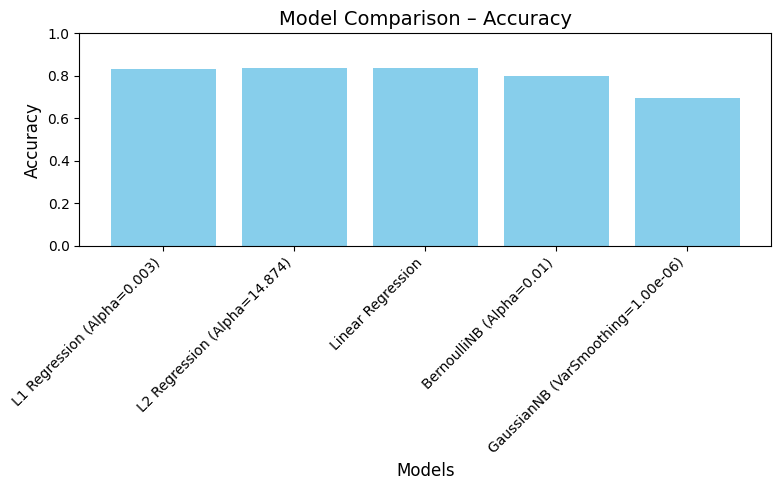

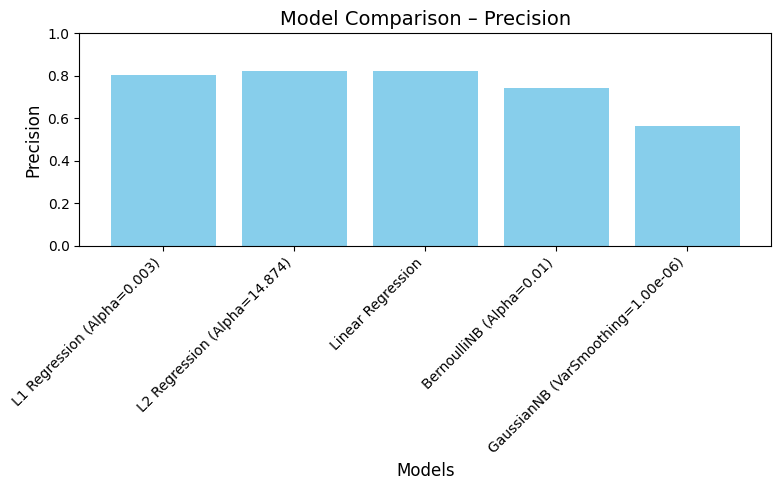

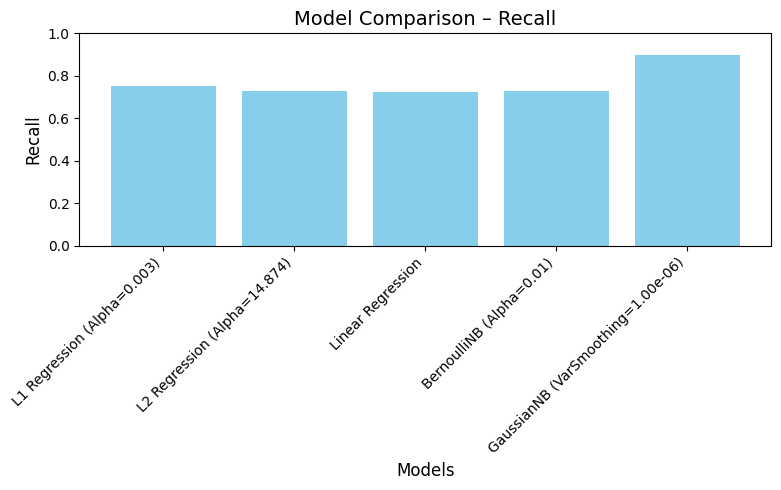

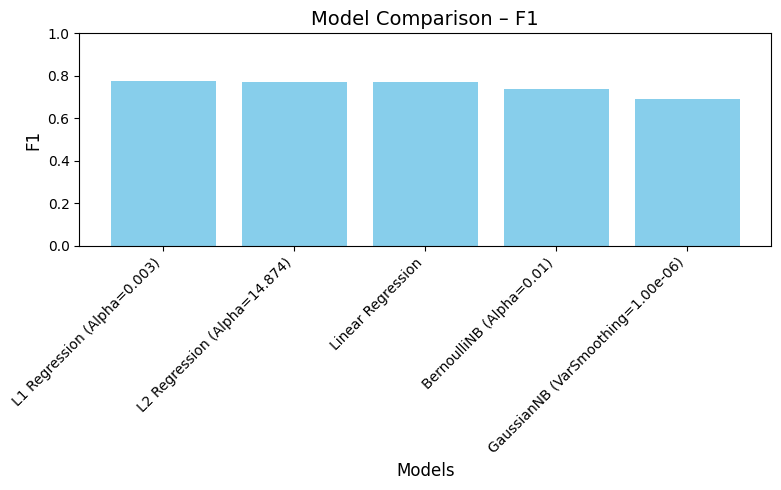

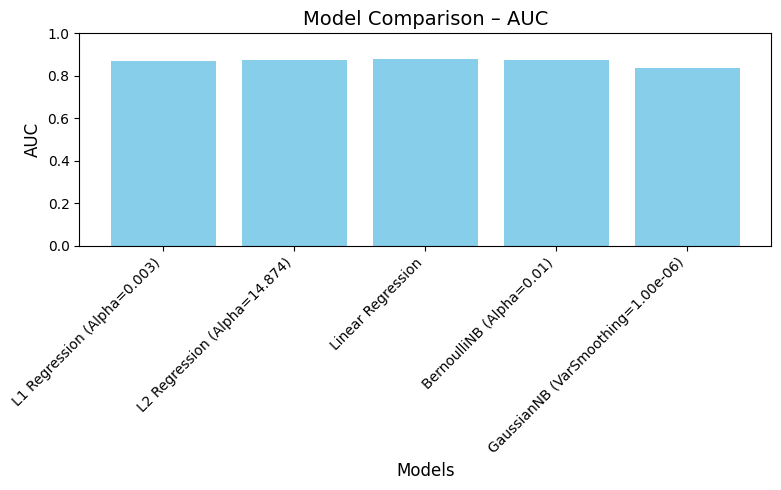

In [137]:
df_plot = df_results.sort_values(by="F1", ascending=False)[ ["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]]

for metric in  ["Accuracy", "Precision", "Recall", "F1", "AUC"]:
    plt.figure(figsize=(8, 5))
    plt.bar(df_plot["Model"], df_plot[metric], color="skyblue")

    # Add title and axis labels
    plt.title(f"Model Comparison – {metric}", fontsize=14)
    plt.xlabel("Models", fontsize=12)
    plt.ylabel(metric, fontsize=12)

    # Improve readability
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)  # all metrics are between 0 and 1

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1895296564.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


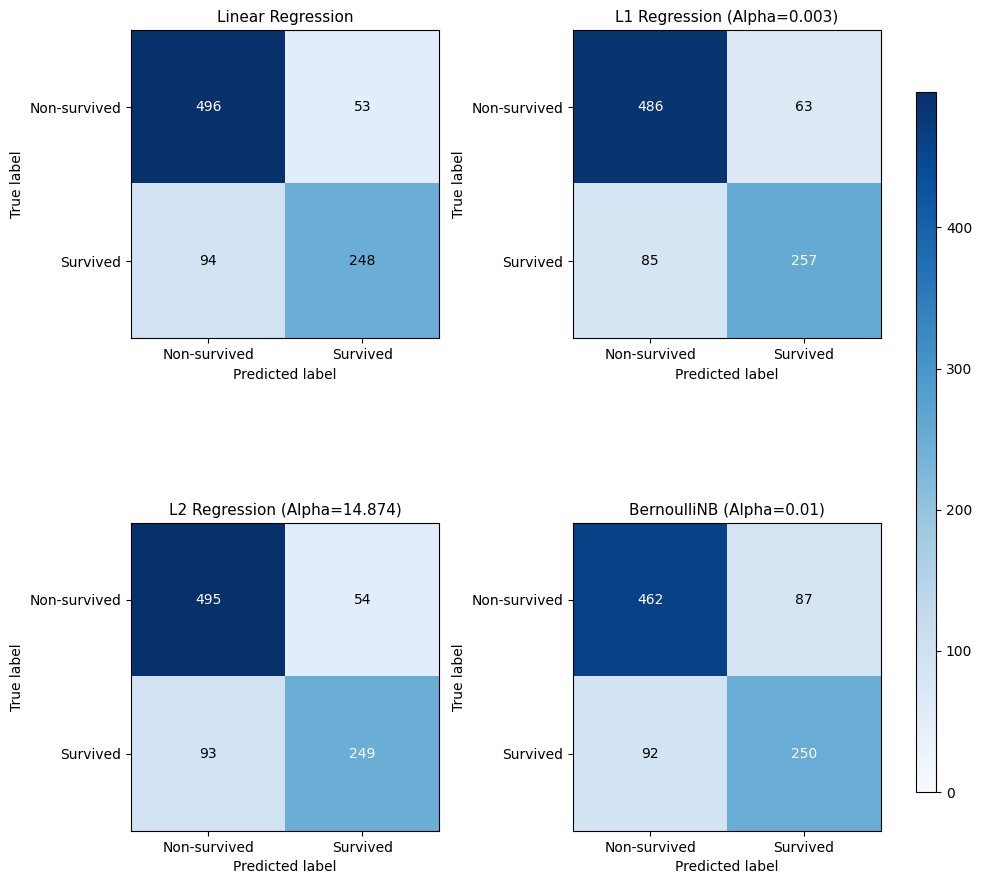

In [138]:
models = df_results["Model"].tolist()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

vmax = df_results[["TN","FP","FN","TP"]].to_numpy().max()  # per scala comune

ims = []
for ax, (_, row) in zip(axes, df_results.iterrows()):
    cm = np.array([[row["TN"], row["FP"]],
                   [row["FN"], row["TP"]]])
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues", vmin=0, vmax=vmax)
    ims.append(im)

    ax.set_title(row["Model"], fontsize=11)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(["Non-survived","Survived"])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(["Non-survived","Survived"])

    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{int(cm[i, j])}",
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")


cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ims[0], cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


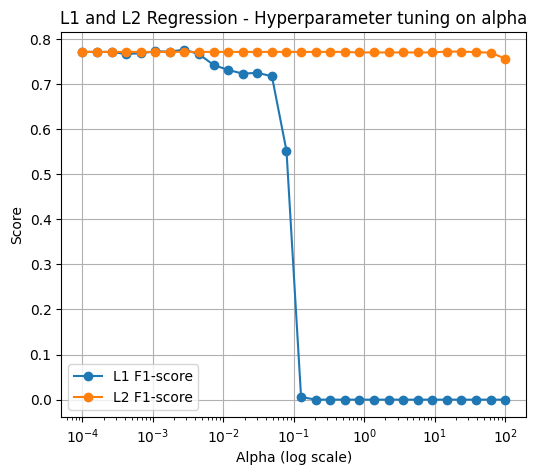

In [139]:
# F1 and Accuracy vs Alpha Plot
plt.figure(figsize=(6, 4))
plt.semilogx(df_l1["alpha"], df_l1["F1"], marker="o", label="L1 F1-score")
plt.semilogx(df_l2["alpha"], df_l2["F1"], marker="o", label="L2 F1-score")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Score")
plt.title("L1 and L2 Regression - Hyperparameter tuning on alpha")
plt.legend()
plt.grid(True)
plt.show()

In [140]:
coef_cv_df

,Feature,Coef_mean,Coef_std
0,LogFare,0.043418,0.007985
1,Sex_male,-0.445760,0.040451
2,Embarked_Q,0.007912,0.025195
3,Embarked_S,-0.051540,0.010642
4,Title_Miss,-0.552179,0.077072
5,Title_Mr,-0.547368,0.031214
6,Title_Mrs,-0.511676,0.071690
7,Title_Other,-0.509418,0.074699
8,Pclass_2,-0.112435,0.005576
9,Pclass_3,-0.223105,0.009738


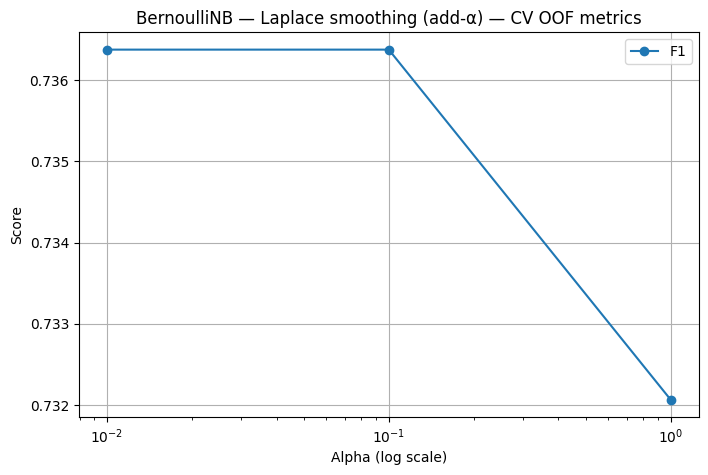

In [141]:
plt.figure(figsize=(8,5))
plt.semilogx(df_nb["alpha"], df_nb["F1"], marker="o", label="F1")

plt.xlabel("Alpha (log scale)")
plt.ylabel("Score")
plt.title("BernoulliNB — Laplace smoothing (add-α) — CV OOF metrics")
plt.legend()
plt.grid(True)
plt.show()